<a href="https://colab.research.google.com/github/Eyalcohenx/SpeechPR/blob/master/speech_enhancement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# checking the gpu
!nvidia-smi

Mon May  4 06:54:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
#installing soundfile
!pip install soundfile

In [4]:
# getting the data from github
!git clone https://github.com/Eyalcohenx/SpeechPR

Cloning into 'SpeechPR'...
remote: Enumerating objects: 24831, done.
remote: Total 24831 (delta 0), reused 0 (delta 0), pack-reused 24831
Receiving objects: 100% (24831/24831), 5.25 GiB | 35.57 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Checking out files: 100% (24795/24795), done.


In [0]:
# this code is responsible to create spectrogram from the sample vector and
# converting the spectrogram back to sample vector

%matplotlib inline
import IPython.display
from ipywidgets import interact, interactive, fixed

# Packages we're using
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.io import wavfile
from scipy.signal import butter, lfilter
import scipy.ndimage
# Most of the Spectrograms and Inversion are taken from: https://gist.github.com/kastnerkyle/179d6e9a88202ab0a2fe


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def overlap(X, window_size, window_step):
    """
    Create an overlapped version of X
    Parameters
    ----------
    X : ndarray, shape=(n_samples,)
        Input signal to window and overlap
    window_size : int
        Size of windows to take
    window_step : int
        Step size between windows
    Returns
    -------
    X_strided : shape=(n_windows, window_size)
        2D array of overlapped X
    """
    if window_size % 2 != 0:
        raise ValueError("Window size must be even!")
    # Make sure there are an even number of windows before stridetricks
    append = np.zeros((window_size - len(X) % window_size))
    X = np.hstack((X, append))

    ws = window_size
    ss = window_step
    a = X

    valid = len(a) - ws
    nw = (valid) // ss
    out = np.ndarray((nw, ws), dtype=a.dtype)

    for i in np.arange(nw):
        # "slide" the window along the samples
        start = i * ss
        stop = start + ws
        out[i] = a[start:stop]

    return out


def stft(
    X, fftsize=128, step=65, mean_normalize=True, real=False, compute_onesided=True
):
    """
    Compute STFT for 1D real valued input X
    """
    if real:
        local_fft = np.fft.rfft
        cut = -1
    else:
        local_fft = np.fft.fft
        cut = None
    if compute_onesided:
        cut = fftsize // 2
    if mean_normalize:
        X -= X.mean()

    X = overlap(X, fftsize, step)

    size = fftsize
    win = 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))
    X = X * win[None]
    X = local_fft(X)[:, :cut]
    return X


def pretty_spectrogram(d, log=True, thresh=5, fft_size=512, step_size=64):
    """
    creates a spectrogram
    log: take the log of the spectrgram
    thresh: threshold minimum power for log spectrogram
    """
    specgram = np.abs(
        stft(d, fftsize=fft_size, step=step_size, real=False, compute_onesided=True)
    )

    if log == True:
        specgram /= specgram.max()  # volume normalize to max 1
        specgram = np.log10(specgram)  # take log
        specgram[
            specgram < -thresh
        ] = -thresh  # set anything less than the threshold as the threshold
    else:
        specgram[
            specgram < thresh
        ] = thresh  # set anything less than the threshold as the threshold

    return specgram


# Also mostly modified or taken from https://gist.github.com/kastnerkyle/179d6e9a88202ab0a2fe
def invert_pretty_spectrogram(
    X_s, log=True, fft_size=512, step_size=512 / 4, n_iter=10
):

    if log == True:
        X_s = np.power(10, X_s)

    X_s = np.concatenate([X_s, X_s[:, ::-1]], axis=1)
    X_t = iterate_invert_spectrogram(X_s, fft_size, step_size, n_iter=n_iter)
    return X_t


def iterate_invert_spectrogram(X_s, fftsize, step, n_iter=10, verbose=False):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    reg = np.max(X_s) / 1e8
    X_best = copy.deepcopy(X_s)
    for i in range(n_iter):
        if verbose:
            print("Runnning iter %i" % i)
        if i == 0:
            X_t = invert_spectrogram(
                X_best, step, calculate_offset=True, set_zero_phase=True
            )
        else:
            # Calculate offset was False in the MATLAB version
            # but in mine it massively improves the result
            # Possible bug in my impl?
            X_t = invert_spectrogram(
                X_best, step, calculate_offset=True, set_zero_phase=False
            )
        est = stft(X_t, fftsize=fftsize, step=step, compute_onesided=False)
        phase = est / np.maximum(reg, np.abs(est))
        X_best = X_s * phase[: len(X_s)]
    X_t = invert_spectrogram(X_best, step, calculate_offset=True, set_zero_phase=False)
    return np.real(X_t)


def invert_spectrogram(X_s, step, calculate_offset=True, set_zero_phase=True):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    size = int(X_s.shape[1] // 2)
    wave = np.zeros((X_s.shape[0] * step + size))
    # Getting overflow warnings with 32 bit...
    wave = wave.astype("float64")
    total_windowing_sum = np.zeros((X_s.shape[0] * step + size))
    win = 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))

    est_start = int(size // 2) - 1
    est_end = est_start + size
    for i in range(X_s.shape[0]):
        wave_start = int(step * i)
        wave_end = wave_start + size
        if set_zero_phase:
            spectral_slice = X_s[i].real + 0j
        else:
            # already complex
            spectral_slice = X_s[i]

        # Don't need fftshift due to different impl.
        wave_est = np.real(np.fft.ifft(spectral_slice))[::-1]
        if calculate_offset and i > 0:
            offset_size = size - step
            if offset_size <= 0:
                print(
                    "WARNING: Large step size >50\% detected! "
                    "This code works best with high overlap - try "
                    "with 75% or greater"
                )
                offset_size = step
            offset = xcorr_offset(
                wave[wave_start : wave_start + offset_size],
                wave_est[est_start : est_start + offset_size],
            )
        else:
            offset = 0
        wave[wave_start:wave_end] += (
            win * wave_est[est_start - offset : est_end - offset]
        )
        total_windowing_sum[wave_start:wave_end] += win
    wave = np.real(wave) / (total_windowing_sum + 1e-6)
    return wave


def xcorr_offset(x1, x2):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    x1 = x1 - x1.mean()
    x2 = x2 - x2.mean()
    frame_size = len(x2)
    half = frame_size // 2
    corrs = np.convolve(x1.astype("float32"), x2[::-1].astype("float32"))
    corrs[:half] = -1e30
    corrs[-half:] = -1e30
    offset = corrs.argmax() - len(x1)
    return offset


def make_mel(spectrogram, mel_filter, shorten_factor=1):
    mel_spec = np.transpose(mel_filter).dot(np.transpose(spectrogram))
    mel_spec = scipy.ndimage.zoom(
        mel_spec.astype("float32"), [1, 1.0 / shorten_factor]
    ).astype("float16")
    mel_spec = mel_spec[:, 1:-1]  # a little hacky but seemingly needed for clipping
    return mel_spec


def mel_to_spectrogram(mel_spec, mel_inversion_filter, spec_thresh, shorten_factor):
    """
    takes in an mel spectrogram and returns a normal spectrogram for inversion 
    """
    mel_spec = mel_spec + spec_thresh
    uncompressed_spec = np.transpose(np.transpose(mel_spec).dot(mel_inversion_filter))
    uncompressed_spec = scipy.ndimage.zoom(
        uncompressed_spec.astype("float32"), [1, shorten_factor]
    ).astype("float16")
    uncompressed_spec = uncompressed_spec - 4
    return uncompressed_spec


# From https://github.com/jameslyons/python_speech_features


def hz2mel(hz):
    """Convert a value in Hertz to Mels
    :param hz: a value in Hz. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Mels. If an array was passed in, an identical sized array is returned.
    """
    return 2595 * np.log10(1 + hz / 700.0)


def mel2hz(mel):
    """Convert a value in Mels to Hertz
    :param mel: a value in Mels. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Hertz. If an array was passed in, an identical sized array is returned.
    """
    return 700 * (10 ** (mel / 2595.0) - 1)


def get_filterbanks(nfilt=20, nfft=512, samplerate=16000, lowfreq=0, highfreq=None):
    """Compute a Mel-filterbank. The filters are stored in the rows, the columns correspond
    to fft bins. The filters are returned as an array of size nfilt * (nfft/2 + 1)
    :param nfilt: the number of filters in the filterbank, default 20.
    :param nfft: the FFT size. Default is 512.
    :param samplerate: the samplerate of the signal we are working with. Affects mel spacing.
    :param lowfreq: lowest band edge of mel filters, default 0 Hz
    :param highfreq: highest band edge of mel filters, default samplerate/2
    :returns: A numpy array of size nfilt * (nfft/2 + 1) containing filterbank. Each row holds 1 filter.
    """
    highfreq = highfreq or samplerate / 2
    assert highfreq <= samplerate / 2, "highfreq is greater than samplerate/2"

    # compute points evenly spaced in mels
    lowmel = hz2mel(lowfreq)
    highmel = hz2mel(highfreq)
    melpoints = np.linspace(lowmel, highmel, nfilt + 2)
    # our points are in Hz, but we use fft bins, so we have to convert
    #  from Hz to fft bin number
    bin = np.floor((nfft + 1) * mel2hz(melpoints) / samplerate)

    fbank = np.zeros([nfilt, nfft // 2])
    for j in range(0, nfilt):
        for i in range(int(bin[j]), int(bin[j + 1])):
            fbank[j, i] = (i - bin[j]) / (bin[j + 1] - bin[j])
        for i in range(int(bin[j + 1]), int(bin[j + 2])):
            fbank[j, i] = (bin[j + 2] - i) / (bin[j + 2] - bin[j + 1])
    return fbank


def create_mel_filter(
    fft_size, n_freq_components=64, start_freq=300, end_freq=8000, samplerate=24000
):
    """
    Creates a filter to convolve with the spectrogram to get out mels

    """
    mel_inversion_filter = get_filterbanks(
        nfilt=n_freq_components,
        nfft=fft_size,
        samplerate=samplerate,
        lowfreq=start_freq,
        highfreq=end_freq,
    )
    # Normalize filter
    mel_filter = mel_inversion_filter.T / mel_inversion_filter.sum(axis=1)

    return mel_filter, mel_inversion_filter

### Parameters ###
fft_size = 256  # window size for the FFT
step_size = fft_size // 16  # distance to slide along the window (in time)
spec_thresh = 4  # threshold for spectrograms (lower filters out more noise)
lowcut = 500  # Hz # Low cut for our butter bandpass filter
highcut = 3999  # Hz # High cut for our butter bandpass filter
# For mels
n_mel_freq_components = 64  # number of mel frequency channels
shorten_factor = 10  # how much should we compress the x-axis (time)
start_freq = 300  # Hz # What frequency to start sampling our melS from
end_freq = 5999  # Hz # What frequency to stop sampling our melS from

def data_to_spectrogram(data, rate):
    # create the spectrogram and returning it
    data = butter_bandpass_filter(data, lowcut, highcut, rate, order=1)
    if np.shape(data)[0] / float(rate) > 10:
        data = data[0 : rate * 10]
    
    wav_spectrogram = pretty_spectrogram(
    data.astype("float64"),
    fft_size=fft_size,
    step_size=step_size,
    log=True,
    thresh=spec_thresh,
    )
    return wav_spectrogram


def plot_spectrogram(wav_spectrogram):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25, 5))
    cax = ax.matshow(
    np.transpose(wav_spectrogram),
    interpolation="nearest",
    aspect="auto",
    cmap=plt.cm.afmhot,
    origin="lower",
    )
    fig.colorbar(cax)
    plt.title("Spectrogram")


def prepare_for_play_audio(data, rate):
    data = butter_bandpass_filter(data, lowcut, highcut, rate, order=1)
    # Only use a short clip for our demo
    if np.shape(data)[0] / float(rate) > 10:
        data = data[0 : rate * 10]
    print("Length in time (s): ", np.shape(data)[0] / float(rate))
    # Play the audio
    return data, rate


def spectrogram_to_audio(wav_spectrogram):
    # Invert from the spectrogram back to a waveform
    recovered_audio_orig = invert_pretty_spectrogram(
    wav_spectrogram, fft_size=fft_size, step_size=step_size, log=True, n_iter=10
    )
    return recovered_audio_orig

In [0]:
# the data loader for the torch model
import os
import os.path
import soundfile as sf
import librosa
import numpy as np
import torch
import torch.utils.data as data
import random
from sklearn.preprocessing import normalize
from sklearn.preprocessing import minmax_scale
AUDIO_EXTENSIONS = [
    '.wav', '.WAV',
]


spect_to_path_dict = dict()


def make_dataset(dir):
    noisy = []
    for root, dirs, files in os.walk(dir + '/noisy'):
        for filename in files[:20000]:
            noisy.append(root + '/' + filename)
    clean = []
    for root, dirs, files in os.walk(dir + '/clean'):
        for filename in files[:20000]:
            clean.append(root + '/' + filename)

    return list(zip(noisy, clean))


def spect_loader4(path_noisy, path_clean, transform=True):
    white_noise = False

    sr, x_noisy = wavfile.read(path_noisy)
    sr, x_clean = wavfile.read(path_clean)

    # matching all the arrays to be 1 seconds
    size = int(sr / 2)
    if len(x_noisy) < size:
        x_noisy = np.pad(x_noisy, (0, size - len(x_noisy)), 'constant')
        x_clean = np.pad(x_clean, (0, size - len(x_clean)), 'constant')
    elif len(x_noisy) > size:
        location_to_slice_from = int(random.randrange(len(x_noisy) - size))
        x_noisy = x_noisy[location_to_slice_from : location_to_slice_from + size]
        x_clean = x_clean[location_to_slice_from : location_to_slice_from + size]

    dilation = 6
    x_noisy = np.copy(x_noisy[::dilation])
    x_clean = np.copy(x_clean[::dilation])
    rate = sr / dilation

    if(white_noise):
        noise = np.random.normal(0,1,int(size / dilation))
        x_noisy = x_clean + noise
    
    spec_noisy = data_to_spectrogram(x_noisy, rate)
    spec_clean = data_to_spectrogram(x_clean, rate)

    # division = 1
    # spec_noisy = spec_noisy[::division,::division]
    # spec_clean = spec_clean[::division,::division]

    if transform:
        spec_clean = minmax_scale(spec_clean, feature_range=(-1,1), axis=0)
        spec_noisy = minmax_scale(spec_noisy, feature_range=(-1,1), axis=0)

    return spec_noisy, spec_clean


class AudioLoader(data.Dataset):

    def __init__(self, root, test_mode=False, transform=None, target_transform=None, window_size=.02,
                 window_stride=.01, window_type='hamming', normalize=True, max_len=101):
        paths = make_dataset(root)
        if len(paths) == 0:
            raise (RuntimeError("Found 0 sound files in subfolders of: " + root +
                                "Supported audio file extensions are: " + ",".join(AUDIO_EXTENSIONS)))

        self.root = root
        self.paths = paths
        self.transform = transform
        self.target_transform = target_transform
        self.loader = spect_loader4
        self.window_size = window_size
        self.window_stride = window_stride
        self.window_type = window_type
        self.normalize = normalize
        self.max_len = max_len
        self.test_mode = test_mode

    def __getitem__(self, index):
        path_noisy, path_clean = self.paths[index]
        spect_noisy, spect_clean = self.loader(path_noisy, path_clean)
        return spect_noisy, spect_clean 


    def __len__(self):
        return len(self.paths)


(240, 128)


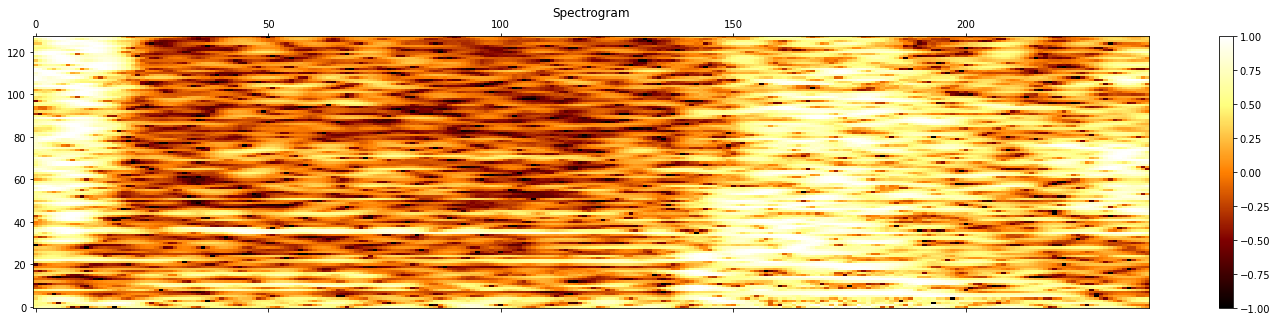

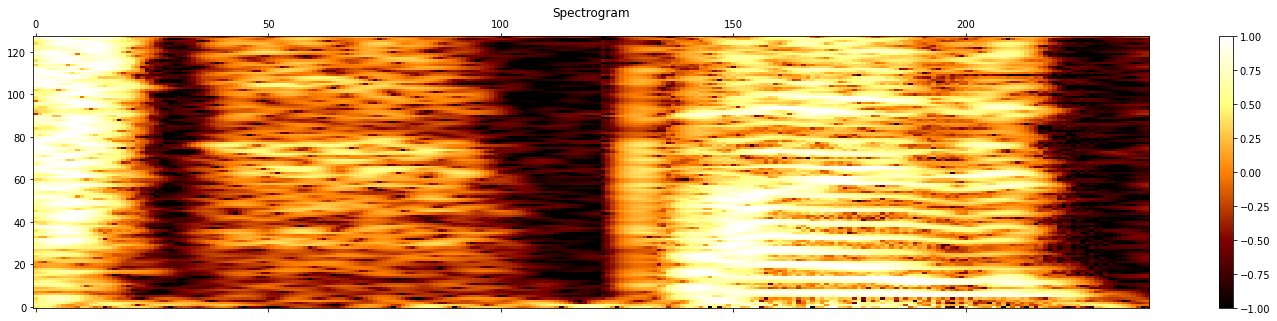

In [113]:
# checking the spectrograms after loading with the spect_loader
x_noisy_spect, x_clean_spect = spect_loader4("SpeechPR/data2/train/noisy/p277_463.wav", "SpeechPR/data2/train/clean/p277_463.wav")
plot_spectrogram(x_noisy_spect)
plot_spectrogram(x_clean_spect)
print(x_clean_spect.shape)
# data = spectrogram_to_audio(x_noisy_spect)
# IPython.display.Audio(data=data, rate=8000)

In [0]:
# the utils class, mainly used here to print the network
import os, torch
import torch.nn as nn
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

torch.manual_seed(1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def log_likelihood_samples_mean_sigma(samples, mean, logvar, dim):
    constant = torch.log(torch.FloatTensor(np.asarray([np.pi]))*2)
    return - constant[0] * samples.shape[dim] * 0.5  - \
               torch.sum(((samples-mean)/torch.exp(logvar*0.5))**2 + logvar, dim=dim) * 0.5

def prior_z(samples, dim):
    constant = torch.log(torch.FloatTensor(np.asarray([np.pi]))*2)
    return - constant[0]*samples.shape[dim] * 0.5 - torch.sum(samples**2, dim=dim) * 0.5

def log_mean_exp(x, dim=1):
    m = torch.max(x, dim=dim, keepdim=True)[0]
    return m + torch.log(torch.mean(torch.exp(x - m), dim=dim, keepdim=True))

def print_network(net):
    num_params = 0
    for param in net.parameters():
        num_params += param.numel()
    print(net)
    print('Total number of parameters: %d' % num_params)

def loss_plot(losses, path ='Train_hist.png', model_name =''):
    x1 = range(len(losses['train']))
    x2 = range(len(losses['dev']))

    y1 = losses['train']
    y2 = losses['dev']

    plt.plot(x1, y1, label='train')
    plt.plot(x2, y2, label='valid')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    path = os.path.join(path, model_name + '_loss.png')
    plt.savefig(path)
    plt.close()

def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [9]:
# the model arcitecture and the training phase
import os

import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiplicativeLR
import torch.nn.functional as F

import soundfile as sf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import random
import gc

torch.cuda.empty_cache()
gc.collect()

num_epochs = 60
batch_size = 64
learning_rate = 0.0001
input_width = 240
input_height = 128

audio_loader_dev = AudioLoader('SpeechPR/data2/dev', test_mode=True)
data_loader_vl = DataLoader(audio_loader_dev, batch_size=batch_size, shuffle=False)
audio_loader_train = AudioLoader('SpeechPR/data2/train')
data_loader_tr = DataLoader(audio_loader_train, batch_size=batch_size, shuffle=False)

def loss_plot(losses, path ='./', model_name ='Conv'):
    x1 = range(len(losses['train']))
    x2 = range(len(losses['dev']))

    y1 = losses['train']
    y2 = losses['dev']

    plt.plot(x1, y1, label='train')
    plt.plot(x2, y2, label='valid')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    path = os.path.join(path, model_name + 'loss.png')
    plt.savefig(path)
    plt.close()

class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.input_width = 48
        self.input_height = 240

        self.conv1_0 = nn.Conv2d(1, 16, 3, stride=1, padding=1)
        self.leaky = nn.LeakyReLU(0.2)
        self.conv1_1 = nn.Conv2d(16, 16, 3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2_0 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.conv2_1 = nn.Conv2d(32, 32, 3, stride=1, padding=1)

        self.conv3_0 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.conv3_1 = nn.Conv2d(64, 64, 3, stride=1, padding=1)

        self.conv4_0 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv4_1 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.drop4 = nn.Dropout(0.5)

        self.conv5_0 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.conv5_1 = nn.Conv2d(256, 256, 3, stride=1, padding=1)

        self.conv_up_6 = nn.Conv2d(256, 128, 3, stride=1, padding=1)
        self.up_sample = nn.Upsample(scale_factor=2, mode='nearest')

        self.conv6_0 = nn.Conv2d(256, 128, 3, stride=1, padding=1)
        self.conv6_1 = nn.Conv2d(128, 128, 3, stride=1, padding=1)

        self.conv_up_7 = nn.Conv2d(128, 64, 3, stride=1, padding=1)

        self.conv7_0 = nn.Conv2d(128, 64, 3, stride=1, padding=1)
        self.conv7_1 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        
        self.conv_up_8 = nn.Conv2d(64, 32, 3, stride=1, padding=1)

        self.conv8_0 = nn.Conv2d(64, 32, 3, stride=1, padding=1)
        self.conv8_1 = nn.Conv2d(32, 32, 3, stride=1, padding=1)

        self.conv_up_9 = nn.Conv2d(32, 16, 3, stride=1, padding=1)

        self.conv9_0 = nn.Conv2d(32, 16, 3, stride=1, padding=1)
        self.conv9_1 = nn.Conv2d(16, 16, 3, stride=1, padding=1)
        self.conv9_2 = nn.Conv2d(16, 2, 3, stride=1, padding=1)

        self.conv10_0 = nn.Conv2d(2, 1, 1, stride=1, padding=0)

        self.tanh = nn.Tanh()
        
    def forward(self, x):
        # ENCODE
        conv1 = self.leaky(self.conv1_0(x))
        pool1 = self.pool(self.leaky(self.conv1_1(conv1)))
        conv2 = self.leaky(self.conv2_0(pool1))
        pool2 = self.pool(self.leaky(self.conv2_1(conv2)))
        conv3 = self.leaky(self.conv3_0(pool2))
        pool3 = self.pool(self.leaky(self.conv3_1(conv3)))
        conv4 = self.leaky(self.conv4_0(pool3))
        drop4 = self.drop4(self.leaky(self.conv4_1(conv4)))
        pool4 = self.pool(drop4)
        conv5 = self.leaky(self.conv5_0(pool4))
        drop5 = self.drop4(self.leaky(self.conv5_1(conv5)))

        # DECODE
        up6 = self.leaky(self.conv_up_6(self.up_sample(drop5)))
        merge6 = torch.cat((drop4,up6), dim=1)
        conv6 = self.leaky(self.conv6_0(merge6))
        conv6 = self.leaky(self.conv6_1(conv6))
        up7 = self.leaky(self.conv_up_7(self.up_sample(conv6)))
        merge7 = torch.cat((conv3,up7), dim=1)
        conv7 = self.leaky(self.conv7_0(merge7))
        conv7 = self.leaky(self.conv7_1(conv7))
        up8 = self.leaky(self.conv_up_8(self.up_sample(conv7)))
        merge8 = torch.cat((conv2,up8), dim=1)
        conv8 = self.leaky(self.conv8_0(merge8))
        conv8 = self.leaky(self.conv8_1(conv8))
        up9 = self.leaky(self.conv_up_9(self.up_sample(conv8)))
        merge9 = torch.cat((conv1,up9), dim=1)
        conv9 = self.leaky(self.conv9_0(merge9))
        conv9 = self.leaky(self.conv9_1(conv9))
        conv9 = self.leaky(self.conv9_2(conv9))
        conv10 = self.conv10_0(conv9)
        tan = self.tanh(conv10)
        return tan

lmbda = lambda epoch: 0.99
model = autoencoder().to(device)
# model.load_state_dict(torch.load('./sim_autoencoder.pth'))
criterion = nn.MSELoss() # TODO: maybe change this to Huberloss, torch.nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = MultiplicativeLR(optimizer, lr_lambda=lmbda)

losses = {'train': [], 'dev': []}
for epoch in range(num_epochs):
    model.train()
    for iter, (x_noisy, x) in enumerate(data_loader_tr):
        x = x[:, None, :, :].float().to(device)
        x_noisy = x_noisy[:, None, :, :].float().to(device)
        x = Variable(x)
        x_noisy = Variable(x_noisy)
        # ===================forward=====================
        output = model(x_noisy)
        loss = criterion(output, x)
        losses['train'].append(loss.item())
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    model.eval()
    for iter, (x_noisy, x) in enumerate(data_loader_vl):
        x = x[:, None, :, :].float().to(device)
        x_noisy = x_noisy[:, None, :, :].float().to(device)
        x = Variable(x)
        x_noisy = Variable(x_noisy)
        # ===================forward=====================
        output = model(x_noisy)
        loss = criterion(output, x)
        losses['dev'].append(loss.item())
    # ===================log========================
    scheduler.step()
    print("Epoch: [%2d] Train loss (MSE): %.8f,  Valid (MSE): %.8f " %
          (epoch + 1, losses['train'][-1], losses['dev'][-1]))

loss_plot(losses)
torch.save(model.state_dict(), './sim_autoencoder3.pth')


Epoch: [ 1] Train loss (MSE): 0.17124324,  Valid (MSE): 0.16052966 
Epoch: [ 2] Train loss (MSE): 0.16061577,  Valid (MSE): 0.11908837 
Epoch: [ 3] Train loss (MSE): 0.12686844,  Valid (MSE): 0.11434752 
Epoch: [ 4] Train loss (MSE): 0.13612010,  Valid (MSE): 0.12065118 
Epoch: [ 5] Train loss (MSE): 0.11913815,  Valid (MSE): 0.10585656 
Epoch: [ 6] Train loss (MSE): 0.14012221,  Valid (MSE): 0.10631671 
Epoch: [ 7] Train loss (MSE): 0.12678316,  Valid (MSE): 0.10478939 
Epoch: [ 8] Train loss (MSE): 0.11909457,  Valid (MSE): 0.10025736 
Epoch: [ 9] Train loss (MSE): 0.11533268,  Valid (MSE): 0.10162336 
Epoch: [10] Train loss (MSE): 0.12308002,  Valid (MSE): 0.11122199 
Epoch: [11] Train loss (MSE): 0.10585802,  Valid (MSE): 0.10830773 
Epoch: [12] Train loss (MSE): 0.10963336,  Valid (MSE): 0.10038560 
Epoch: [13] Train loss (MSE): 0.11824359,  Valid (MSE): 0.11243345 
Epoch: [14] Train loss (MSE): 0.14303894,  Valid (MSE): 0.09509059 
Epoch: [15] Train loss (MSE): 0.11981419,  Valid

In [0]:
# spect_loader for the test
def spect_loader_test(path_noisy, path_clean, transform=True):
    white_noise = False

    sr, x_noisy = wavfile.read(path_noisy)
    sr, x_clean = wavfile.read(path_clean)

    spects_noisy = []
    spects_clean = []

    # matching all the arrays to be 1 seconds
    size = int(sr / 2)
    times_to_cut = int(len(x_clean) / size)

    for i in range(times_to_cut):
        if len(x_noisy) > size:
            location_to_slice_from = int(i * size)
            x_noisy_cut = x_noisy[location_to_slice_from : location_to_slice_from + size]
            x_clean_cut = x_clean[location_to_slice_from : location_to_slice_from + size]
        else:
            print("too short")
        dilation = 6
        x_noisy_cut = np.copy(x_noisy_cut[::dilation])
        x_clean_cut = np.copy(x_clean_cut[::dilation])
        rate = sr / dilation

        if(white_noise):
            noise = np.random.normal(0,1,int(size / dilation))
            x_noisy_cut = x_clean_cut + noise
    
        spec_noisy = data_to_spectrogram(x_noisy_cut, rate)
        spec_clean = data_to_spectrogram(x_clean_cut, rate)

        if transform:
            spec_clean = minmax_scale(spec_clean, feature_range=(-1,1), axis=0)
            spec_noisy = minmax_scale(spec_noisy, feature_range=(-1,1), axis=0)

        spects_noisy.append(spec_noisy)
        spects_clean.append(spec_clean)

    return np.asarray(spects_noisy), np.asarray(spects_clean)

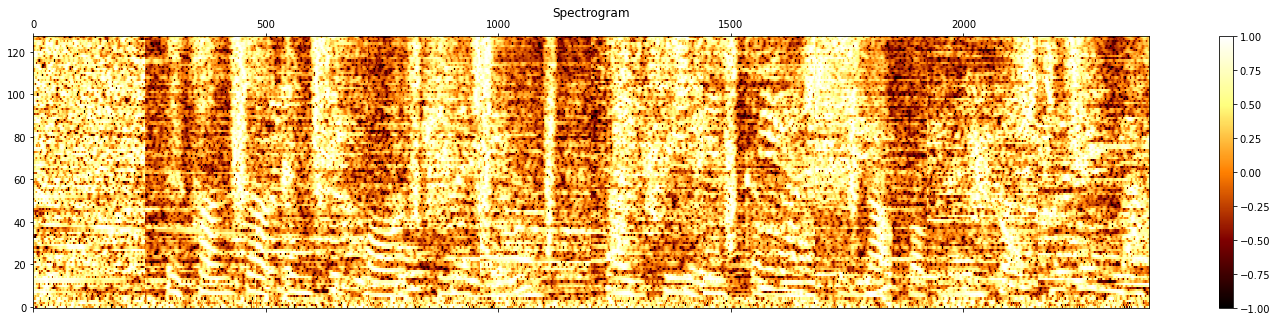

In [115]:
# loading the spectrograms and padding with zeros to fit the size of the batch.
x_noisy_spects, x_clean_spects = spect_loader_test("SpeechPR/data2/train/noisy/p277_463.wav", "SpeechPR/data2/train/clean/p277_463.wav")
zeros_matrix = np.zeros((input_width, input_height))

# adding the zeros and sending to the model to clean
x_input_noisy = np.append(x_noisy_spects, np.vstack([[zeros_matrix]] * (batch_size - len(x_clean_spects))), axis=0)[:, None, :, :]
output = model(torch.Tensor(x_input_noisy).float().to(device))

# flatning the arrays back to one large audio
x_noisy_spect = x_noisy_spects.reshape((-1, input_height))
x_clean_spect = x_clean_spects.reshape((-1, input_height))
model_spec = np.asarray(output.cpu().tolist())[0:len(x_clean_spects)].reshape((-1, input_height))

# plotting the noisy spectrogram
plot_spectrogram(x_noisy_spect)
data = spectrogram_to_audio(x_noisy_spect)
IPython.display.Audio(data=data, rate=8000)

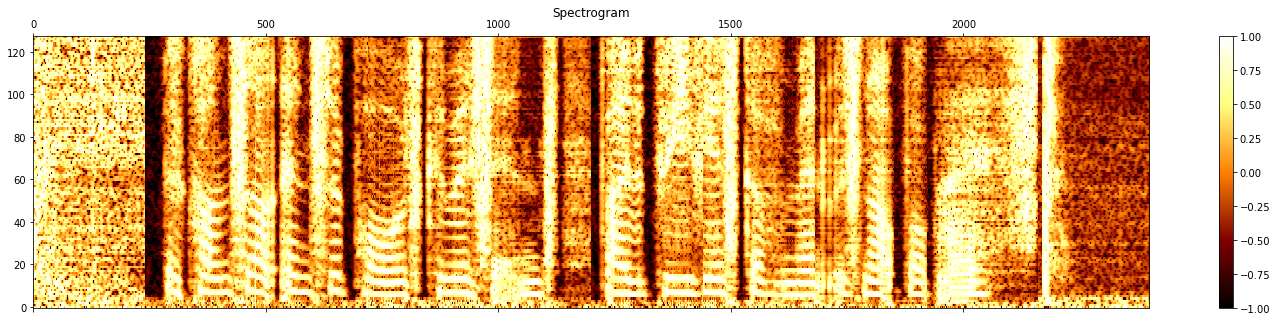

In [116]:
# plotting the clean spectrogram
plot_spectrogram(x_clean_spect)
data = spectrogram_to_audio(x_clean_spect)
IPython.display.Audio(data=data, rate=8000)

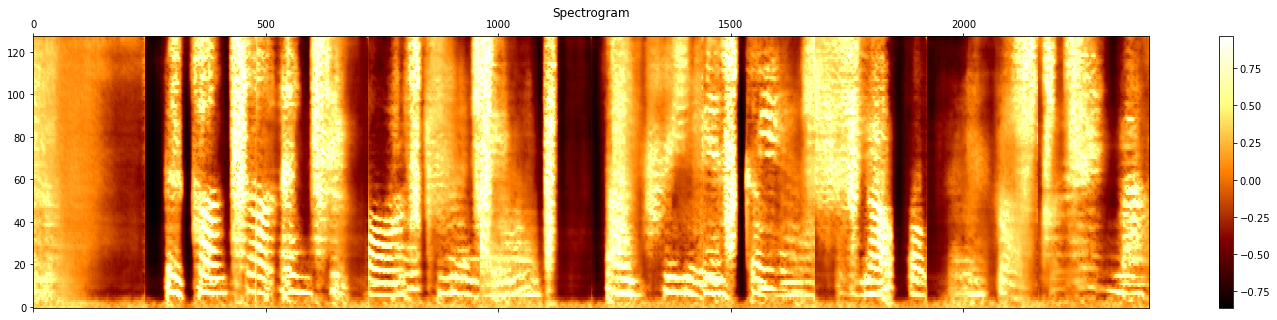

In [93]:
# plotting the output spectrogram
plot_spectrogram(model_spec)
data = spectrogram_to_audio(model_spec)
IPython.display.Audio(data=data, rate=8000)

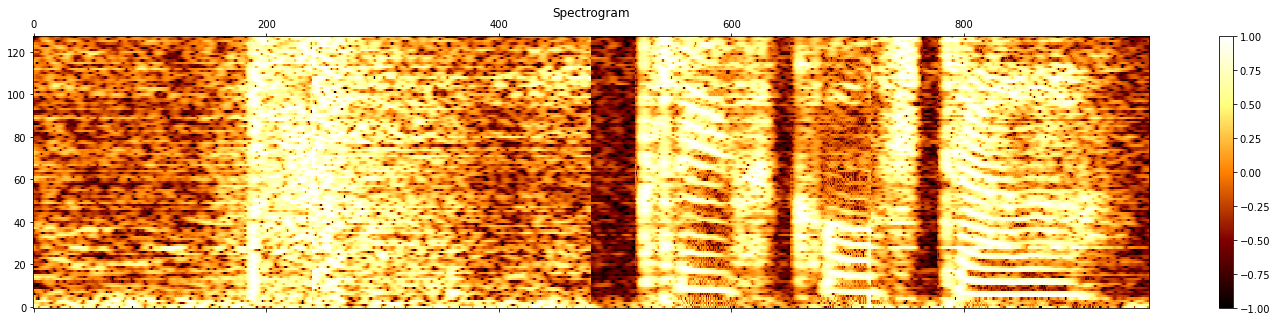

In [95]:
# same from here just for other files
x_noisy_spects, x_clean_spects = spect_loader_test("/content/SpeechPR/data2/dev/noisy/p257_001.wav", "/content/SpeechPR/data2/dev/clean/p257_001.wav")
zeros_matrix = np.zeros((input_width, input_height))

x_input_noisy = np.append(x_noisy_spects, np.vstack([[zeros_matrix]] * (batch_size - len(x_clean_spects))), axis=0)[:, None, :, :]
output = model(torch.Tensor(x_input_noisy).float().to(device))

x_noisy_spect = x_noisy_spects.reshape((-1, input_height))
x_clean_spect = x_clean_spects.reshape((-1, input_height))
model_spec = np.asarray(output.cpu().tolist())[0:len(x_clean_spects)].reshape((-1, input_height))

plot_spectrogram(x_noisy_spect)
data = spectrogram_to_audio(x_noisy_spect)
IPython.display.Audio(data=data, rate=8000)

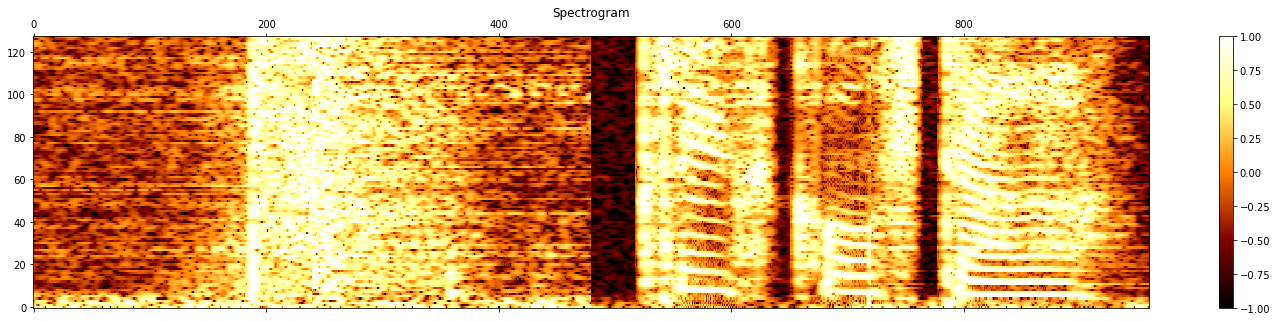

In [96]:
plot_spectrogram(x_clean_spect)
data = spectrogram_to_audio(x_clean_spect)
IPython.display.Audio(data=data, rate=8000)

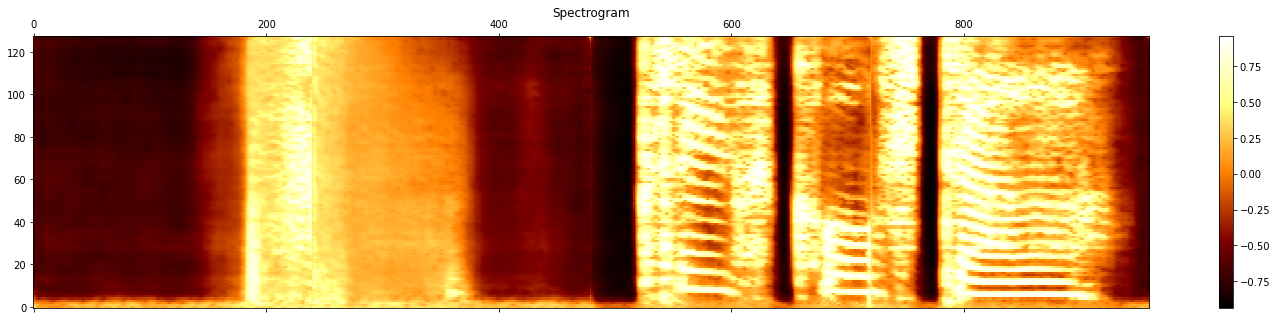

In [97]:
plot_spectrogram(model_spec)
data = spectrogram_to_audio(model_spec)
IPython.display.Audio(data=data, rate=8000)

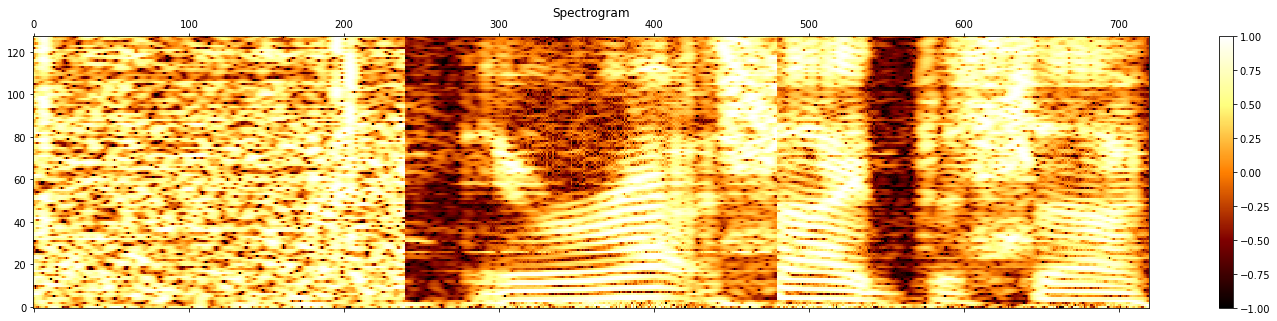

In [104]:
torch.cuda.empty_cache()
gc.collect()
x_noisy_spects, x_clean_spects = spect_loader_test("/content/SpeechPR/data2/dev/noisy/p232_101.wav", "/content/SpeechPR/data2/dev/clean/p232_101.wav")
zeros_matrix = np.zeros((input_width, input_height))

x_input_noisy = np.append(x_noisy_spects, np.vstack([[zeros_matrix]] * (batch_size - len(x_clean_spects))), axis=0)[:, None, :, :]
output = model(torch.Tensor(x_input_noisy).float().to(device))

x_noisy_spect = x_noisy_spects.reshape((-1, input_height))
x_clean_spect = x_clean_spects.reshape((-1, input_height))
model_spec = np.asarray(output.cpu().tolist())[0:len(x_clean_spects)].reshape((-1, input_height))

plot_spectrogram(x_noisy_spect)
data = spectrogram_to_audio(x_noisy_spect)
IPython.display.Audio(data=data, rate=8000)

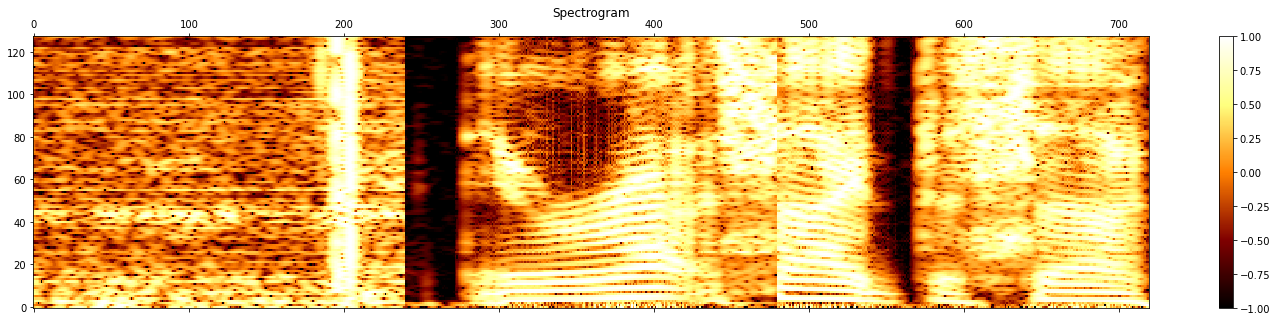

In [105]:
plot_spectrogram(x_clean_spect)
data = spectrogram_to_audio(x_clean_spect)
IPython.display.Audio(data=data, rate=8000)

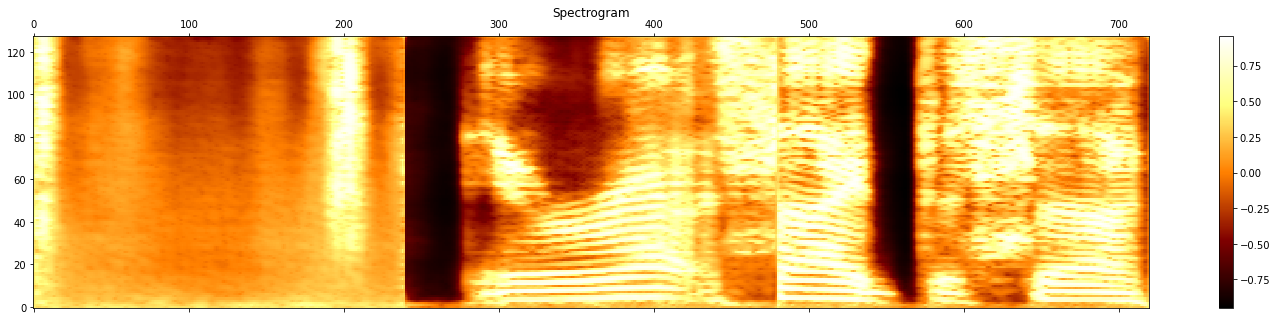

In [106]:
plot_spectrogram(model_spec)
data = spectrogram_to_audio(model_spec)
IPython.display.Audio(data=data, rate=8000)

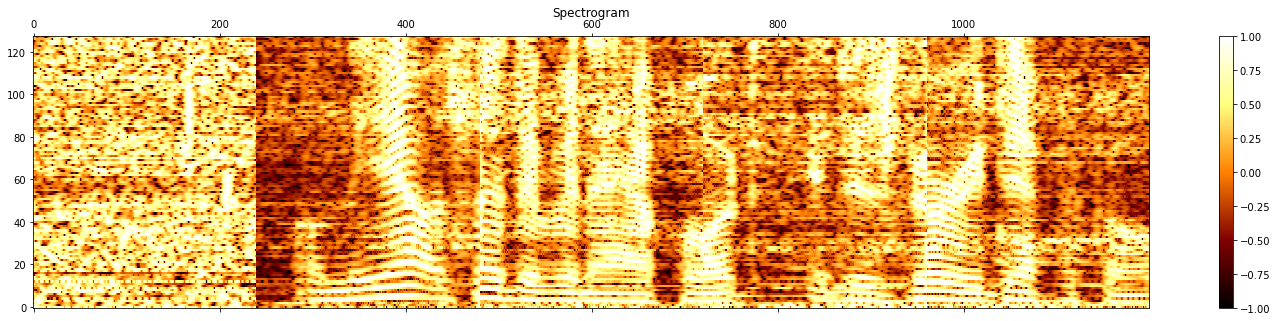

In [107]:
torch.cuda.empty_cache()
gc.collect()
x_noisy_spects, x_clean_spects = spect_loader_test("/content/SpeechPR/data2/dev/noisy/p232_201.wav", "/content/SpeechPR/data2/dev/clean/p232_201.wav")
zeros_matrix = np.zeros((input_width, input_height))

x_input_noisy = np.append(x_noisy_spects, np.vstack([[zeros_matrix]] * (batch_size - len(x_clean_spects))), axis=0)[:, None, :, :]
output = model(torch.Tensor(x_input_noisy).float().to(device))

x_noisy_spect = x_noisy_spects.reshape((-1, input_height))
x_clean_spect = x_clean_spects.reshape((-1, input_height))
model_spec = np.asarray(output.cpu().tolist())[0:len(x_clean_spects)].reshape((-1, input_height))

plot_spectrogram(x_noisy_spect)
data = spectrogram_to_audio(x_noisy_spect)
IPython.display.Audio(data=data, rate=8000)

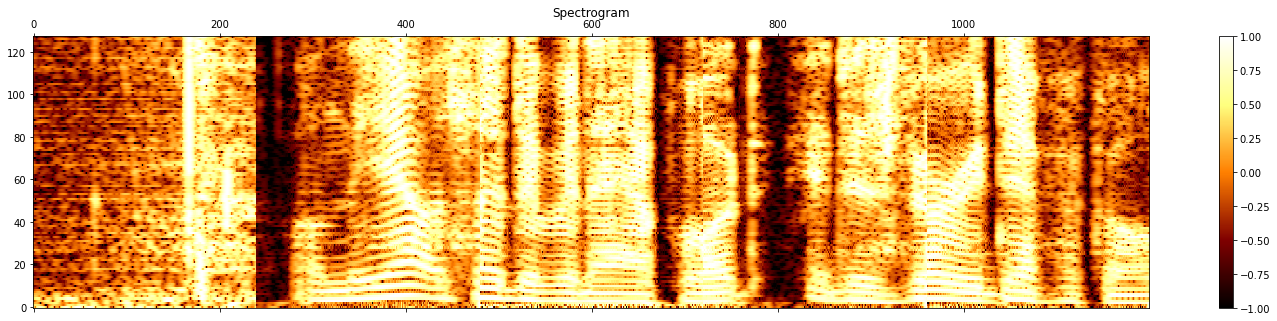

In [108]:
plot_spectrogram(x_clean_spect)
data = spectrogram_to_audio(x_clean_spect)
IPython.display.Audio(data=data, rate=8000)

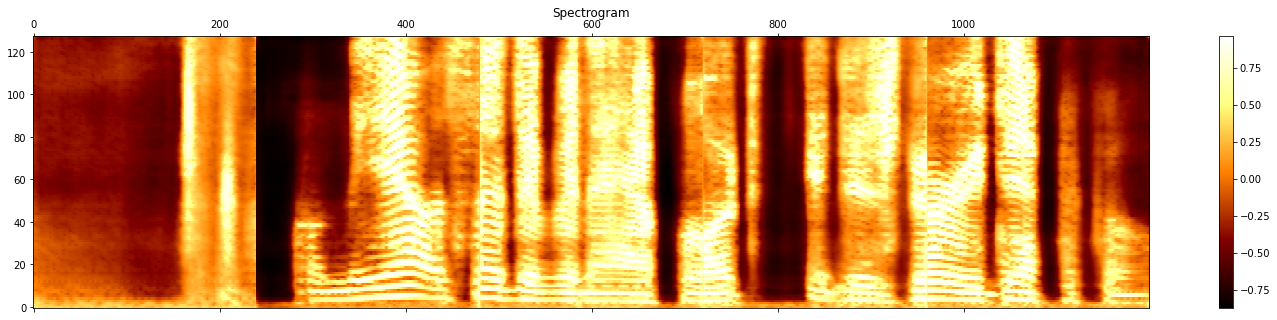

In [109]:
plot_spectrogram(model_spec)
data = spectrogram_to_audio(model_spec)
IPython.display.Audio(data=data, rate=8000)

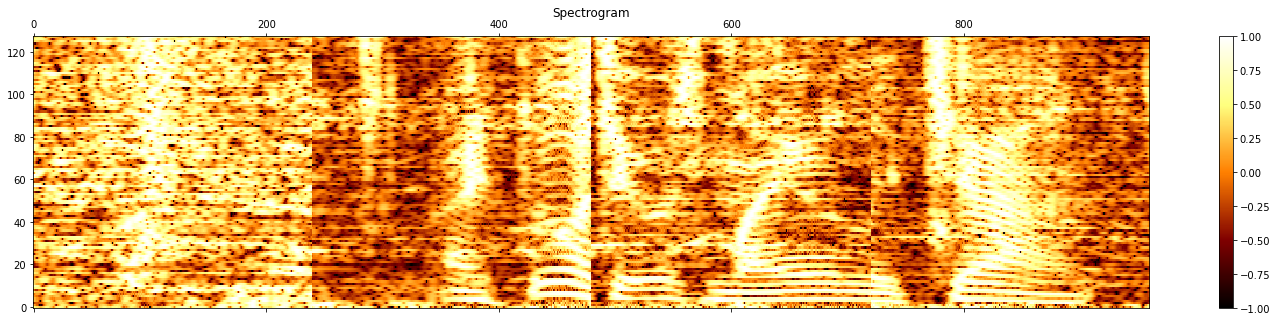

In [110]:
torch.cuda.empty_cache()
gc.collect()
x_noisy_spects, x_clean_spects = spect_loader_test("/content/SpeechPR/data2/dev/noisy/p232_301.wav", "/content/SpeechPR/data2/dev/clean/p232_301.wav")
zeros_matrix = np.zeros((input_width, input_height))

x_input_noisy = np.append(x_noisy_spects, np.vstack([[zeros_matrix]] * (batch_size - len(x_clean_spects))), axis=0)[:, None, :, :]
output = model(torch.Tensor(x_input_noisy).float().to(device))

x_noisy_spect = x_noisy_spects.reshape((-1, input_height))
x_clean_spect = x_clean_spects.reshape((-1, input_height))
model_spec = np.asarray(output.cpu().tolist())[0:len(x_clean_spects)].reshape((-1, input_height))

plot_spectrogram(x_noisy_spect)
data = spectrogram_to_audio(x_noisy_spect)
IPython.display.Audio(data=data, rate=8000)

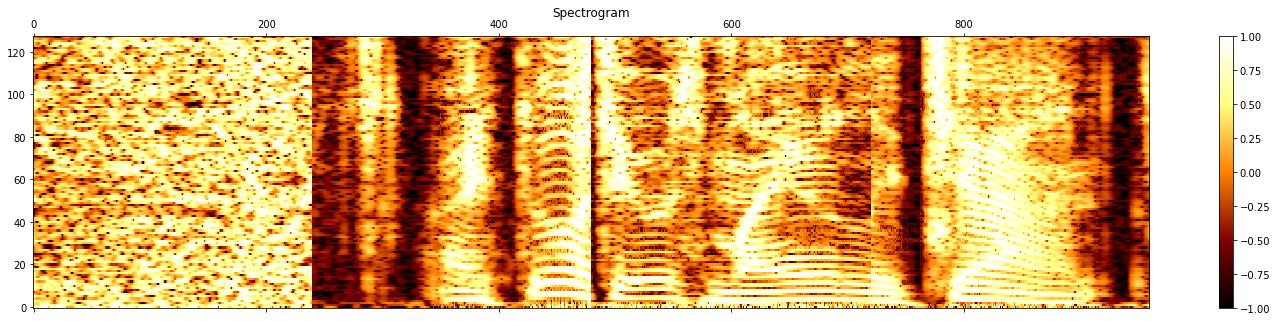

In [111]:
plot_spectrogram(x_clean_spect)
data = spectrogram_to_audio(x_clean_spect)
IPython.display.Audio(data=data, rate=8000)

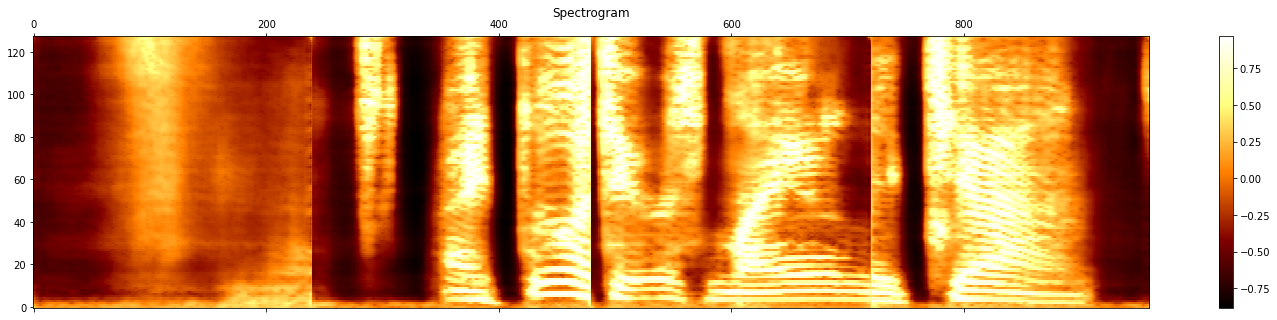

In [112]:
plot_spectrogram(model_spec)
data = spectrogram_to_audio(model_spec)
IPython.display.Audio(data=data, rate=8000)